In [207]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import log_parser
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from mizani.formatters import scientific_format
from scipy import stats
from pathlib import Path
import re
sns.set_theme(color_codes=True)

datasets = {
    "Video_Games.txt (0.47 GB)": "E:\\webdata_datasets\\videogames\\log.txt",
    "Music.txt (6.3 GB)": "E:\\webdata_datasets\\music-long\\log.txt",
    "all.txt (35 GB)": "E:\\webdata_datasets\\all-long-varint\\log.txt",
}

def get_index_size(path):
    path = Path(path).parent
    size = 0
    for file in path.glob("**/*"):
        if "temp_indices" in str(file) or "bin-externalSort" in str(file) or file.is_dir():
            continue
        size += file.stat().st_size
    return size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
def load_logfile(path, label):
    df, df2 = log_parser.parse_log_file(path)
    df["time"] = df["time"].dt.total_seconds()
    df2["time"] = df2["time"].dt.total_seconds()
    df["dataset"] =  label
    df2["dataset"] = label
    
    return df, df2

dfs = []
df2s = []
for label, path in datasets.items():
    try:
        df, df2 = load_logfile(path, label)
        dfs.append(df)
        df2s.append(df2)
        df2s[-1]["final_index_size"] = get_index_size(path)
    except IOError:
        print("Couldn't load ", path)

df = pd.concat(dfs)
df2 = pd.concat(df2s)

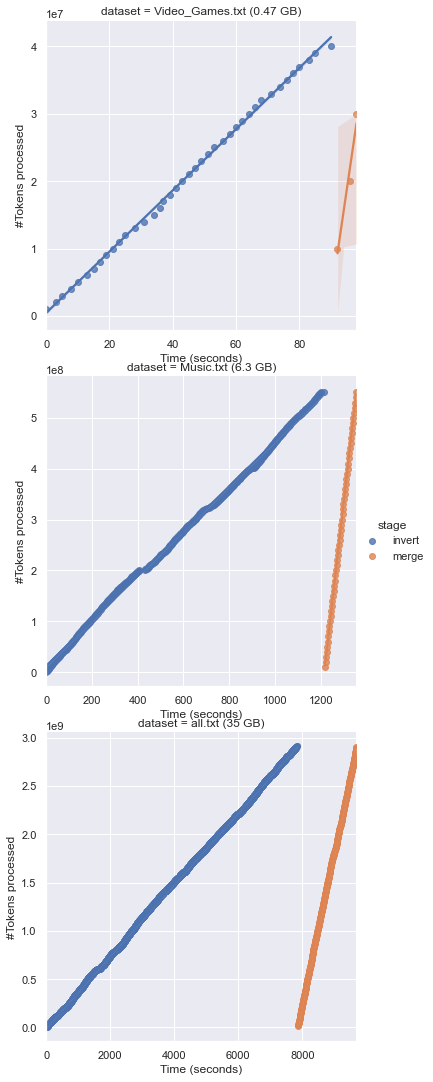

In [137]:
plot = (p9.ggplot(df, p9.aes(x="time", y="numTokens", color="stage")) 
    + p9.geom_line()
    + p9.labs(x="Time (minutes)", y="#Tokens processed", title="Number of tokens processed over time")
    + p9.scale_y_continuous(labels=scientific_format(digits=2))
    + p9.facet_wrap("dataset", scales="free", ncol=1)
    + p9.theme(subplots_adjust={'hspace': 1.25})
    )
plot
ax = sns.lmplot(data=df, x="time", y="numTokens", hue="stage", row="dataset", sharex=False, sharey=False)
ax.set(xlabel="Time (seconds)", ylabel="#Tokens processed")
plt.show()
ax.savefig("runtime.pdf")

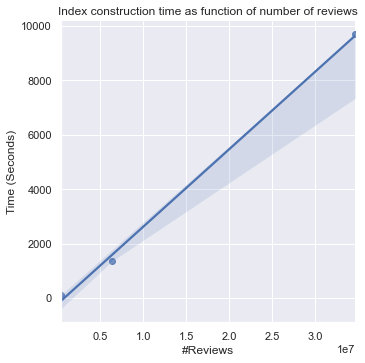

In [140]:
time_per_review = df.groupby("dataset")[["total_reviews", "time"]].max().reset_index()
ax = sns.lmplot(data=time_per_review, x="total_reviews", y="time")
ax.set(xlabel="#Reviews", ylabel="Time (Seconds)", title="Index construction time as function of number of reviews")
plt.show()
ax.savefig("runtime2.pdf")

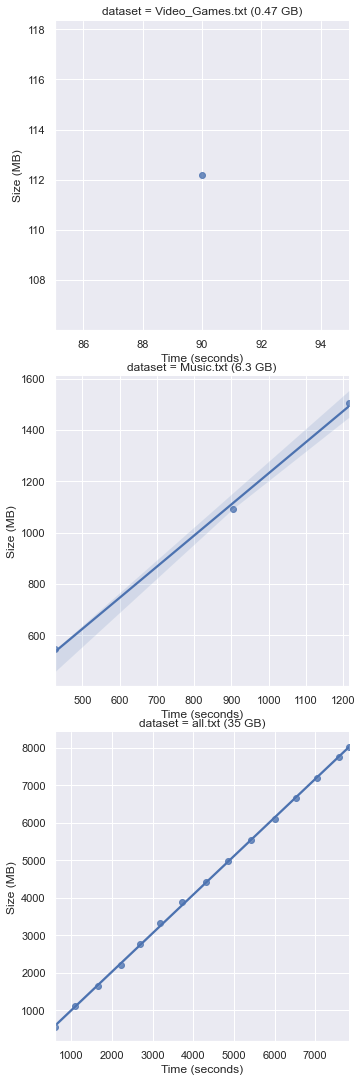

In [141]:
df2["index_size"] = df2["total_index_size"]/(1000 * 1000)

ax2 = sns.lmplot(data=df2, x="time", y="index_size", row="dataset", sharex=False, sharey=False)

ax2.set(xlabel="Time (seconds)", ylabel="Size (MB)")
plt.show()
ax2.savefig("diskusage.pdf")

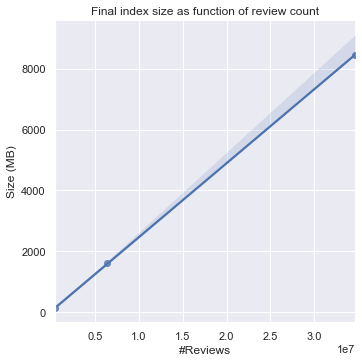

In [210]:
size_df = df2.groupby("dataset")[["total_reviews", "time", "final_index_size"]].max().reset_index()
size_df["final_index_size"] = size_df["final_index_size"] / (1000 * 1000)
ax = sns.lmplot(data=size_df, x="total_reviews", y="final_index_size")
ax.set(xlabel="#Reviews", ylabel="Size (MB)", title="Final index size as function of review count")
plt.show()
ax.savefig("diskusage2.pdf")

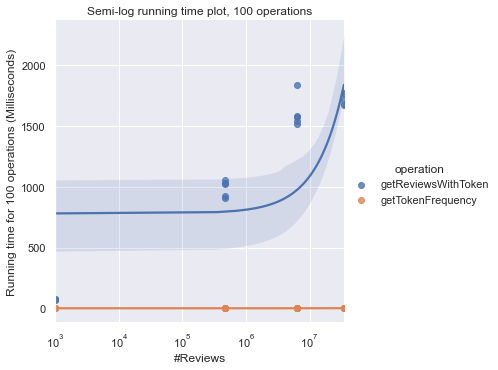

In [248]:
anDf = pd.read_csv("C:\\Users\\Daniel Kerbel\\University\\webdata\\proj\\analysis\\analysis.csv")
anDf["totalTime"] = anDf["totalTimeNs"] / 1e6
ax = sns.lmplot(data=anDf, x="numReviews", y="totalTime", hue="operation")
ax.set(xscale="log")
ax.set(xlabel="#Reviews", ylabel="Running time for 100 operations (Milliseconds)", title="Semi-log running time plot, 100 operations")
plt.show()
ax.savefig("ops.pdf")